<a href="https://colab.research.google.com/github/Hedredo/dagshub_p7/blob/main/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Work in Progress**

**MLFlow**
- Ajouter une description aux runs mlflow
- Résoudre les dernières erreurs sur un run mlflow
- Ajouter en artifact la matrice de confusion et tester la fonction `plot_confusion_matrix` de `sklearn`
- Ajouter en artifact la courbe ROC et tester la fonction `plot_roc_curve` de `sklearn`
- Simplifier les appels aux différents paramètres et variables pour automatiser simplement le process
- Créer un pipeline pour le tfidf
- Créer une grille d'hyperparamètres pour le tfidf
- Créer une grille d'hyperparamètres pour le modèle
- Créer une fonction pour tester les différents modèles
- Créer une liste des architectures preprocessing + modèle + hyperparamètres
- Utiliser mflow.log_dict pour les hyperparamètres du preprocessing
- Finaliser la fonction de preprocessing avec des True/False pour les différentes étapes en match_case


**Modèle RN inspiré de KERAS**
- Créer un modèle de réseaux de neurones inspiré de KERAS

# **Configuration de l'environnement**

In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy_langdetect import LanguageDetector
from spacy.language import Language
from spacymoji import Emoji
from nltk.tokenize import TweetTokenizer
import time
from sklearn.preprocessing import LabelEncoder
from collections import namedtuple
from tqdm import tqdm
from tensorflow.config import list_physical_devices
from typing import Union, List
import pickle

2024-11-08 11:34:53.975573: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-08 11:34:54.857366: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2024-11-08 11:34:54.857451: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2024-11-08 11:34:54.862700: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
Dropped Escape call with ulEscapeCode : 0x03007703
Dropped Escape call with ulEscapeCode : 0x03007703
2024-11-08 11:34:55.453946: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.


In [6]:
# Remove FutureWarning alerts
warnings.filterwarnings("ignore", category=FutureWarning)

# Check if GPU and CUDA are available
gpu = list_physical_devices("GPU")
print("Tensorflow framework: GPU is", "available" if gpu else "NOT AVAILABLE")

# Initialize tdqm pandas
tqdm.pandas()

Tensorflow framework: GPU is available


# **Chargement des données**

In [42]:
# Path to the csv file
path = "../data/raw/training.1600000.processed.noemoticon.csv"

In [43]:
# Read the file
df = pd.read_csv(
    path,
    header=None,
    names=["target", "ids", "date", "flag", "user", "text"],
    usecols=["target", "ids", "date", "user", "text"],  # remove flag column
    parse_dates=["date"],
    encoding="utf-8",
    encoding_errors="replace",  # replace the errors with unicode symbol � (U+FFFD)
).sort_values(by="date", ascending=True)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1600000 entries, 0 to 799999
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   target  1600000 non-null  int64         
 1   ids     1600000 non-null  int64         
 2   date    1600000 non-null  datetime64[ns]
 3   user    1600000 non-null  object        
 4   text    1600000 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 73.2+ MB


# **Analyse pré-exploratoire et préparation des données**

In [45]:
# Initialize the encoder
encoder = LabelEncoder()

# Encode the desired columns
for col in ["ids", "user"]:
    df[col] = encoder.fit_transform(df[col])

# Replace 4 with 1 in the target column
df["target"] = df["target"].replace(4, 1)

# Finally, create new columns for month, day, and hour and drop date
df = df.assign(
    **{
        "month": lambda x: x.date.progress_apply(lambda x: x.month),
        "day": lambda x: x.date.progress_apply(lambda x: x.day),
        "hour": lambda x: x.date.progress_apply(lambda x: x.hour),
    }
).drop(columns=["date"])

100%|██████████| 1600000/1600000 [00:02<00:00, 761338.98it/s] 


In [46]:
# Convert the datatypes to save memory
df = df.astype(
    {
        "target": "int8",
        "ids": "int32",
        "user": "int32",
        "month": "int8",
        "day": "int8",
        "hour": "int8",
    }
)

In [47]:
df.head()

,target,ids,user,text,month,day,hour
0,0,0,242711,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",4,6,22
1,0,1,577449,is upset that he can't update his Facebook by ...,4,6,22
2,0,2,490699,@Kenichan I dived many times for the ball. Man...,4,6,22
3,0,3,65794,my whole body feels itchy and like its on fire,4,6,22
4,0,4,113308,"@nationwideclass no, it's not behaving at all....",4,6,22


In [48]:
print(df.duplicated().sum(), "duplicata trouvé.")
print(
    df.duplicated(subset=["ids", "target", "text"]).sum(),
    "duplicata trouvé sur les colonnes ids, target et text.",
)

0 duplicata trouvé.
0 duplicata trouvé sur les colonnes ids, target et text.


In [49]:
print("Nombre de tweets uniques: ", df["ids"].nunique())
print(
    "Nombre de tweets annotés à la fois positivement et négativement: ",
    df["ids"].size - df["ids"].nunique(),
)

Nombre de tweets uniques:  1598315
Nombre de tweets annotés à la fois positivement et négativement:  1685


On doit retirer ces tweets qui ont deux valeurs car cela va complexifier la capacité du modèle a bien séparé les classes s'ils sont ambiguës.<br>
Regardons un exemple de tweet avec deux valeurs:

In [50]:
# Display 4 examples of duplicated rows with both positive and negative target
with pd.option_context("display.max_colwidth", 150):
    display(df.loc[df["ids"].duplicated(keep=False), ["text", "target"]].head(4))

,text,target
800261,Awwh babs... you look so sad underneith that shop entrance of &quot;Yesterday's Musik&quot; O-: I like the look of the new transformer movie,1
213,Awwh babs... you look so sad underneith that shop entrance of &quot;Yesterday's Musik&quot; O-: I like the look of the new transformer movie,0
800300,"Haven't tweeted nearly all day Posted my website tonight, hopefully that goes well Night time!",1
275,"Haven't tweeted nearly all day Posted my website tonight, hopefully that goes well Night time!",0


In [51]:
# Drop duplicates ids with both positive and negative target
df = df.drop_duplicates(subset=["ids"], keep=False)
print(
    "Nouvelle taille du jeu de données après suppression des duplicata sur ids: ",
    len(df),
)

Nouvelle taille du jeu de données après suppression des duplicata sur ids:  1596630


# **Exploration des données**

In [52]:
# Display the summary statistics of numerical columns
with pd.option_context(
    "display.max_colwidth", 100, "display.float_format", "{:.2f}".format
):
    display(df.describe())

,target,ids,user,month,day,hour
count,1596630.00,1596630.00,1596630.00,1596630.00,1596630.00,1596630.00
mean,0.50,799301.29,330323.25,5.51,14.81,10.96
std,0.50,461450.15,191341.79,0.61,9.79,7.22
min,0.00,0.00,0.00,4.00,1.00,0.00
25%,0.00,399669.25,164668.00,5.00,6.00,5.00
50%,0.50,799342.50,329997.00,6.00,16.00,10.00
75%,1.00,1199004.75,496888.75,6.00,21.00,18.00
max,1.00,1598314.00,659774.00,6.00,31.00,23.00


In [53]:
# Statistics of the number of tweets per user
df["user"].value_counts().describe()

count    659502.000000
mean          2.420963
std           4.697115
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         549.000000
Name: count, dtype: float64

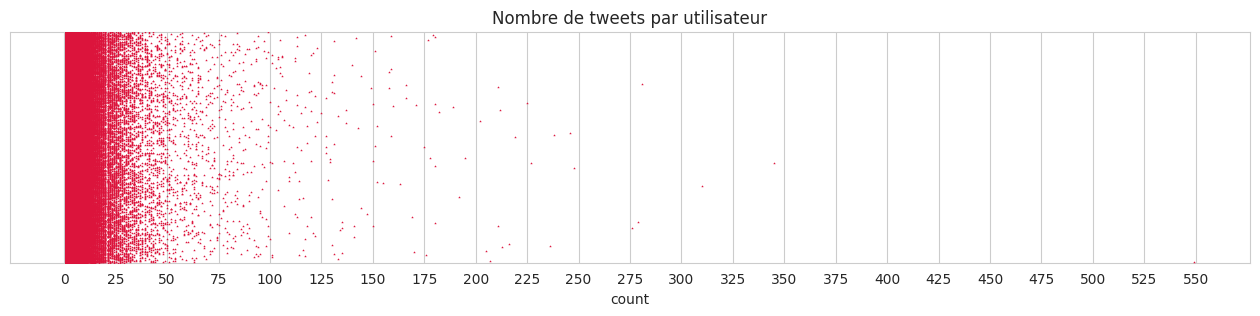

In [54]:
# Show a stripplot of the number of tweets per user
fig, ax = plt.subplots(figsize=(16, 3))
sns.stripplot(
    x=df["user"].value_counts(), jitter=0.5, size=2, marker="*", color="crimson", ax=ax
)
ax.set_title("Nombre de tweets par utilisateur")
ax.set_xticks(range(0, 575, 25))
plt.show()

Un nombre très limité d'utilisateurs tweet énormément alors que la moyenne sur le jeu de données est de 2,4 tweets par utilisateur.<br>
Il n'est pas possible de prendre en compte cette variable dans le modèle car elle peut introduire un biais par ces utilisateurs qui tweentent beaucoup.<br>

In [55]:
# Creation of a palette with 2 colors, crimson and deepskyblue
palette = sns.color_palette(["crimson", "deepskyblue"])

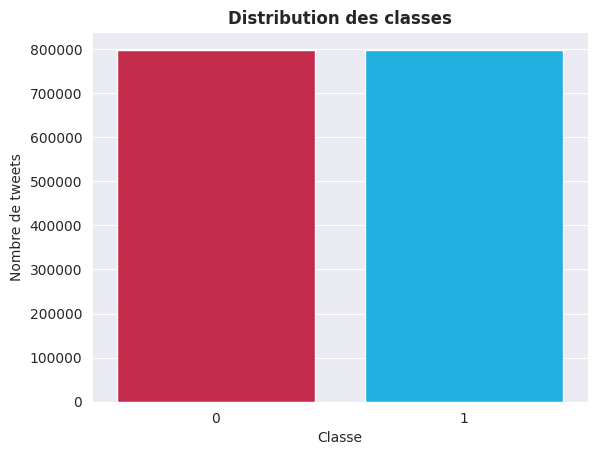

In [56]:
with sns.axes_style("darkgrid"):
    sns.countplot(df, x="target", palette=palette)
    plt.title("Distribution des classes", fontweight="bold")
    plt.xlabel("Classe")
    plt.ylabel("Nombre de tweets")
    plt.show()

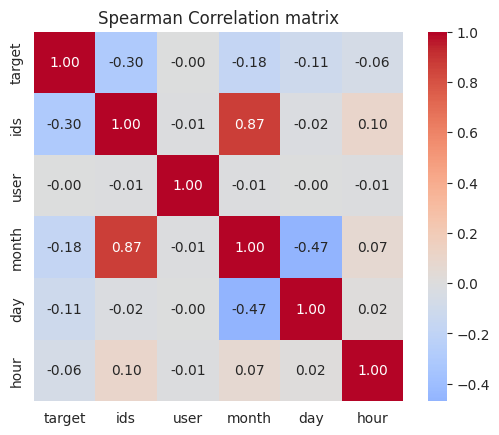

In [57]:
sns.heatmap(
    df.select_dtypes(exclude=["object"]).corr("spearman"),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
)
plt.title("Spearman Correlation matrix")
plt.show()

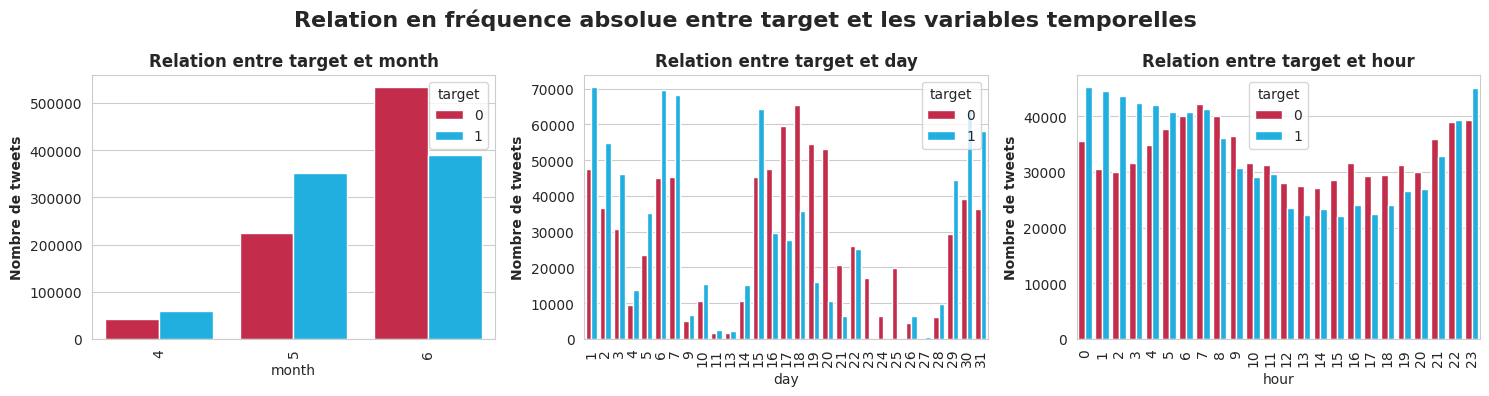

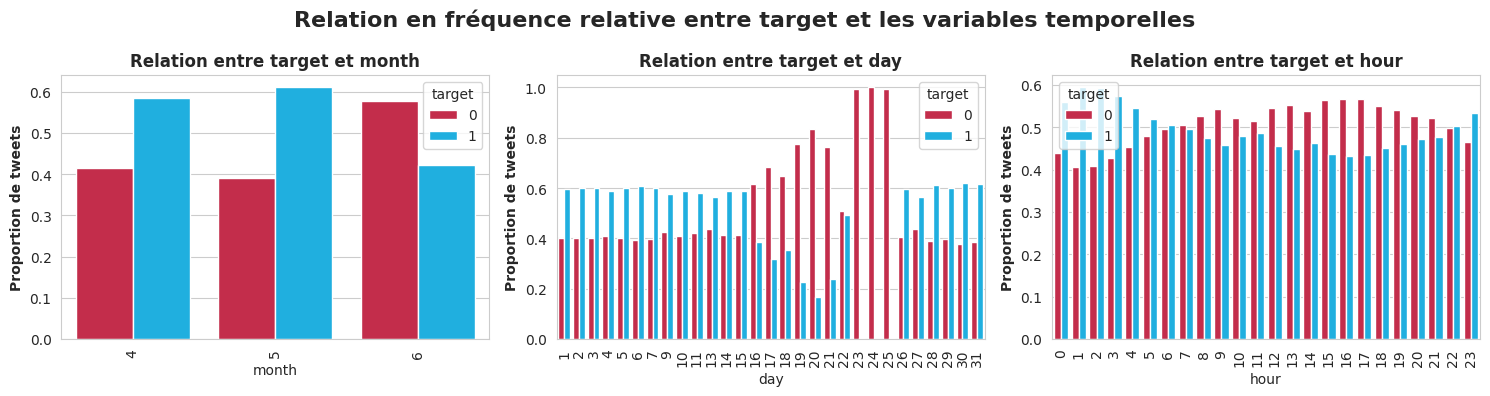

In [58]:
# Display the relation between target and the variables month, day, and hour
for title, method in zip(("absolue", "relative"), ("count", "proportion")):
    fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=False, tight_layout=True)
    fig.suptitle(
        f"Relation en fréquence {title} entre target et les variables temporelles",
        fontweight="bold",
        fontsize=16,
    )
    sns.set_style("whitegrid")
    for i, col in enumerate(["month", "day", "hour"]):
        sns.barplot(
            df.groupby(col)["target"]
            .value_counts(normalize=True if title == "relative" else False)
            .reset_index(),
            x=col,
            y=method,
            hue="target",
            palette=palette,
            ax=ax[i],
        )
        ax[i].set_title(f"Relation entre target et {col}", fontweight="bold")
        ax[i].set_xlabel(col)
        ax[i].set_ylabel(
            "Proportion de tweets" if title == "relative" else "Nombre de tweets",
            fontweight="bold",
        )
        ax[i].set_xticks(ax[i].get_xticks())
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
    plt.show()

On peut noter que **certaines journées ne sont pas présentes (le 8 et le 12)**.<br>
Pour une raison inconnue, les jours 23, 24 et 25 sont uniquement **négatifs**.<br>
La répartition des tweets n'est pas uniforme **sur les mois**, avec une concentration beaucoup plus forte en mai (+ de positif) et en juin (+ de négatif) qu'en avril avec la faible relation linéaire négative identifiée dans la matrice de corrélation.<br>

On identifie deux relations non linéaires à:
- **l'échelle journalière**: Les tweets négatifs sont plus fréquents en milieu de mois et les tweets positifs en début et fin de mois.
- **l'échelle horaire**: on a un cycle en forme d'ADN, la nuit étant plus propice aux tweets positifs, la tendance s'inversant durant la matinée avant de voir l'après-midi plus propice aux tweets négatifs


Dans l'absolu, **seule la variable horaire semble avoir un lien avec la target**. Les autres variables sont  biaisées par leur fréquence relative déséquilibrée.

In [59]:
# Sélection de données restreintes
df = df.filter(["target", "text", "hour"])

# Assign the len of the preprocessed dataframe
n_rows = len(df)

Commençons par avoir un aperçu d'une sélection de tweets aléatoires:

In [60]:
with pd.option_context("display.max_colwidth", 150):
    display(df[["text", "target"]].sample(25))

,text,target
1302339,Seems like work will be hectic all week long. This is why I love the weekends,1
879844,nooooo extension maths tomorow... at least exams are over after that,1
1569014,Watching &quot;East of Eden&quot; on TCM I heart James Dean !,1
486610,@DaniiLovesDiana FRICK. It's not letting me vote Hasn't let me since last night :\,0
128953,@NiGhT_RaVeN13 bad luck bet you cba now,0
497099,its 8:53 i'm tired and about to go to bed. i feel old but its too boring to stay awake.,0
1312930,oooh snap!!!! one of my fav shows is on HALF AND HALF... peace out twittas I'll be back sometime today,1
172729,ugh... dunno why im just not in the best of moods... how do i know if i have allergies? meh...,0
11408,"@MacKenzieFox Thanks, It's also about to RAIN I am hibernating.... lol",0
420754,So my bro did not arrive yesterday he is only flying here on thursday. Hoping for something good to happen,0


# **Création des corpus**

In [61]:
# Load a spacy model of your choice
spacy_model = "en_core_web_sm"
disable = ["ner"]

# Check if gpu is available to use it with spacy
if gpu:
    spacy.prefer_gpu()

# Load the model without the ner component and download it if needed
try:
    nlp = spacy.load(spacy_model, disable=disable)
except OSError as e:
    print(e)
    print(f"Downloading the {spacy_model} model...")
    spacy.cli.download(spacy_model)
    # Add sleep time
    time.sleep(5)
    # Finally load the model
    print("Loading the model...")
    nlp = spacy.load(spacy_model, disable=disable)
finally:
    print(f"{spacy_model.upper()} model loaded successfully :)")
    print(f"Model components: {nlp.pipe_names}")


EN_CORE_WEB_SM model loaded successfully :)
Model components: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer']


In [62]:
# Add the language detector variable name
name = "language_detector"

# Register the language detector as a component and add it as a component
if name not in Language.factories.keys():

    @Language.factory(name)
    def create_language_detector(nlp, name):
        return LanguageDetector()


# Add the language detection component to the pipeline if it's not already added
if name not in nlp.pipe_names:
    nlp.add_pipe(name, last=True)

print("Language detection component added to the pipeline as {}.".format(name))

Language detection component added to the pipeline as language_detector.


In [63]:
# Add the emoji detector variable name
name = "emoji_detector"

# Register the emoji detector as a component and add it as a component
if name not in Language.factories.keys():

    @Language.factory(name)
    def create_emoji_detector(nlp, name):
        return Emoji(nlp)


# Add the language detection component to the pipeline if it's not already added
if name not in nlp.pipe_names:
    nlp.add_pipe(name, first=True)

print("Emoji detection component added to the pipeline as {}.".format(name))

Emoji detection component added to the pipeline as emoji_detector.


In [64]:
# Define the named tuple
TokenParams = namedtuple(
    "TokenParams",
    ["library", "description", "params", "tokenizer", "model_name", "fit_time"],
)

In [65]:
# Create the token_methods list using the named tuple
token_methods = [
    TokenParams(
        "spacy",
        "tokenizer with lowercase",
        (params := lambda doc: [token.text.lower() for token in doc]),
        nlp,
        spacy_model,
        0,
    ),
    TokenParams(
        "nltk",
        "tokenizer with lowercase, handle stripping, and length reduction",
        (params := dict(preserve_case=False, strip_handles=True, reduce_len=True)),
        TweetTokenizer(**params).tokenize,
        "TweetTokenizer",
        0,
    ),
    TokenParams(
        "spacy",
        "tokenizer with lowercase and alpha",
        (
            params := lambda doc: [
                token.lemma_.lower() for token in doc if token.is_alpha
            ]
        ),
        nlp,
        spacy_model,
        0,
    ),
    TokenParams(
        "spacy",
        "tokenizer with lowercase, alpha and emoji",
        (
            params := lambda doc: [
                token.lemma_.lower()
                for token in doc
                if token.is_alpha or token._.is_emoji
            ]
        ),
        nlp,
        spacy_model,
        0,
    ),
    TokenParams(
        "spacy",
        "tokenizer with lowercase, alpha, and no stop words",
        (
            params := lambda doc: [
                token.lemma_.lower()
                for token in doc
                if not token.is_stop and token.is_alpha
            ]
        ),
        nlp,
        spacy_model,
        0,
    ),
    TokenParams(
        "spacy",
        "tokenizer with lowercase, alpha and emoji, and no stop words",
        (
            params := lambda doc: [
                token.lemma_.lower()
                for token in doc
                if not token.is_stop and token.is_alpha or token._.is_emoji
            ]
        ),
        nlp,
        spacy_model,
        0,
    ),
]

In [66]:
def spacy_preprocess(
    texts: Union[List[str], np.ndarray, pd.Series], TokenParams: namedtuple
) -> list:
    """
    Preprocess a list of texts using the spacy model and the tokenizer
    """
    assert isinstance(
        texts, (list, np.ndarray, pd.Series)
    ), "The input must be a sequence (list, array or series) of texts."
    preprocessed_texts = []
    # Process the texts
    for text in tqdm(TokenParams.tokenizer.pipe(texts)):
        # Tokenize the text
        tokens = TokenParams.params(text)
        preprocessed_texts.append(" ".join(tokens))
    return preprocessed_texts

In [67]:
def nltk_preprocess(
    texts: Union[List[str], np.ndarray, pd.Series], TokenParams: namedtuple
) -> list:
    """
    Preprocess a list of texts using the nltk tokenizer
    """
    assert isinstance(
        texts, (list, np.ndarray, pd.Series)
    ), "The input must be a sequence (list, array or series) of texts."
    preprocessed_texts = []
    # Process the texts
    for text in tqdm(texts):
        # Tokenize the text
        tokens = TokenParams.tokenizer(text)
        preprocessed_texts.append(" ".join(tokens))
    return preprocessed_texts

In [68]:
for token_method in token_methods:
    match token_method.library:
        case "spacy":
            start_time = time.time()
            df[token_method.description] = spacy_preprocess(df["text"], token_method)
            token_method = token_method._replace(fit_time=time.time() - start_time)
        case "nltk":
            start_time = time.time()
            df[token_method.description] = nltk_preprocess(df["text"], token_method)
            token_method = token_method._replace(fit_time=time.time() - start_time)

1596630it [19:03, 1396.51it/s]
100%|██████████| 1596630/1596630 [01:21<00:00, 19602.28it/s]
1596630it [18:36, 1429.48it/s]
1596630it [18:44, 1419.92it/s]
1596630it [18:31, 1436.08it/s]
1596630it [18:57, 1403.91it/s]


Le tokenizer de spacy a été beaucoup long à exécuter que celui de NLTK.<br>
Spacy propose plus de possibilités uniquement avec les lemmes qui demandent à garder certains éléments du pipeline actif.<br>
Le tokenizer de NLTK est une alternative qui permets de tester rapidement des modèles.<br>

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1596630 entries, 0 to 799999
Data columns (total 9 columns):
 #   Column                                                            Non-Null Count    Dtype 
---  ------                                                            --------------    ----- 
 0   target                                                            1596630 non-null  int8  
 1   text                                                              1596630 non-null  object
 2   hour                                                              1596630 non-null  int8  
 3   tokenizer with lowercase                                          1596630 non-null  object
 4   tokenizer with lowercase, handle stripping, and length reduction  1596630 non-null  object
 5   tokenizer with lowercase and alpha                                1596630 non-null  object
 6   tokenizer with lowercase, alpha and emoji                         1596630 non-null  object
 7   tokenizer with lowercase,

In [70]:
# Save the preprocessed dataframe as a parquet file
df.to_parquet("../data/processed/df_preprocessed.parquet")

In [75]:
# Save the columns names in a pickle file
with open("../data/processed/columns.pkl", "wb") as f:
    pickle.dump(df.columns, f)